In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import Conv2DVAE, bce_loss, gaussian_kld, load_mnist, plot_digits
from plot_utils import save_comparison, save_samples

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

2024-06-24 03:08:36.279198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def run(latent_dim):

    output_dim = 784
    batch_size = 64
    epochs = 100
    seed = 42

    batches, ds_test = load_mnist(
        batch_size=batch_size,
        drop_remainder=True,
        select_digits=[0, 1, 2, 3],
        as_supervised=False,
        binarized=True,
        shuffle=True,
        shuffle_seed=42,
    )

    # set values for learning rate scheduler
    total_steps = len(batches) * epochs
    init_lr = 1e-3
    alpha_lr = 1e-2

    ds_test = ds_test.reshape(-1, 28, 28, 1)
    ds_test = jax.device_put(ds_test)

    def model():
        return Conv2DVAE(latent_dim)

    def init_model(rng):
        rng, init_key = random.split(rng)

        initial_variables = jnp.ones((batch_size, 28, 28, 1), jnp.float32)
        params = model().init(init_key, initial_variables, rng)["params"]
        del initial_variables, init_key

        lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
        optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

        state = train_state.TrainState.create(
            apply_fn=model().apply,
            params=params,
            tx=optimizer,
        )
        return rng, state

    def compute_metrics(recon_x, x, mean, logvar):
        bce = bce_loss(recon_x, x).mean()  # mean over batch
        kld = gaussian_kld(mean, logvar).mean()  # mean over batch
        elbo = bce + kld
        return {"elbo": elbo, "bce": bce, "kld": kld}

    @jax.jit
    def train_step(state, batch, z_rng):

        def loss_fn(params):
            recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
            bce = bce_loss(recon_x, batch).mean()
            kld = gaussian_kld(mean, logvar).mean()
            elbo = bce + kld
            return elbo

        grads = jax.grad(loss_fn)(state.params)
        return state.apply_gradients(grads=grads)

    @jax.jit
    def eval_f(params, images, z, z_rng):
        def eval_model(vae):
            recon_images, mean, logvar = vae(images, z_rng)

            recon_images_compare = nn.sigmoid(recon_images[:8])
            comparison = jnp.concatenate(
                [
                    images[:8],
                    recon_images_compare,
                ]
            )

            generate_images = vae.generate(z, assumption="bernoulli")
            generate_images = generate_images
            metrics = compute_metrics(recon_images, images, mean, logvar)
            return metrics, comparison, generate_images

        return nn.apply(eval_model, model())({"params": params})

    rng = random.key(seed)
    rng, state = init_model(rng)

    rng, z_key, eval_rng = random.split(rng, 3)

    z = random.normal(z_key, (batch_size, latent_dim))  # prior
    del z_key

    epoch_metrics = []
    for epoch in range(epochs):
        for batch in batches:
            batch = batch.reshape(-1, 28, 28, 1)
            rng, key = random.split(rng)
            state = train_step(state, batch, key)

        metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
        metrics["epoch"] = epoch + 1
        epoch_metrics.append(metrics)
        print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

    df = pd.DataFrame(epoch_metrics)
    df.to_csv(f"./vae_data/latent_dim_{latent_dim}_vanilla_conv_vae_bmnist.csv", index=False)
    save_comparison(comparison, f"recon_latent_dim_{latent_dim}_vanilla_conv_vae_bmnist.pdf")
    save_samples(samples, f"samples_latent_dim_{latent_dim}_vanilla_conv_vae_bmnist.pdf")

epoch: 1, ELBO: 173.1921, BCE: 170.0701, KLD: 3.1220
epoch: 2, ELBO: 164.4522, BCE: 160.9971, KLD: 3.4550
epoch: 3, ELBO: 161.6778, BCE: 158.0664, KLD: 3.6115
epoch: 4, ELBO: 159.3664, BCE: 155.6818, KLD: 3.6846
epoch: 5, ELBO: 156.8557, BCE: 153.1636, KLD: 3.6920
epoch: 6, ELBO: 154.2938, BCE: 150.3603, KLD: 3.9335
epoch: 7, ELBO: 152.4523, BCE: 148.3420, KLD: 4.1103
epoch: 8, ELBO: 151.5173, BCE: 147.4559, KLD: 4.0614
epoch: 9, ELBO: 150.5250, BCE: 146.3691, KLD: 4.1559
epoch: 10, ELBO: 149.5789, BCE: 145.4816, KLD: 4.0973
epoch: 11, ELBO: 149.0537, BCE: 144.9592, KLD: 4.0945
epoch: 12, ELBO: 148.9111, BCE: 144.6301, KLD: 4.2810
epoch: 13, ELBO: 149.5280, BCE: 145.2465, KLD: 4.2816
epoch: 14, ELBO: 148.1653, BCE: 143.8201, KLD: 4.3452
epoch: 15, ELBO: 147.9111, BCE: 143.7787, KLD: 4.1323
epoch: 16, ELBO: 148.3403, BCE: 144.1363, KLD: 4.2039
epoch: 17, ELBO: 148.1080, BCE: 143.7906, KLD: 4.3173
epoch: 18, ELBO: 147.4127, BCE: 143.0417, KLD: 4.3710
epoch: 19, ELBO: 147.7457, BCE: 143.4

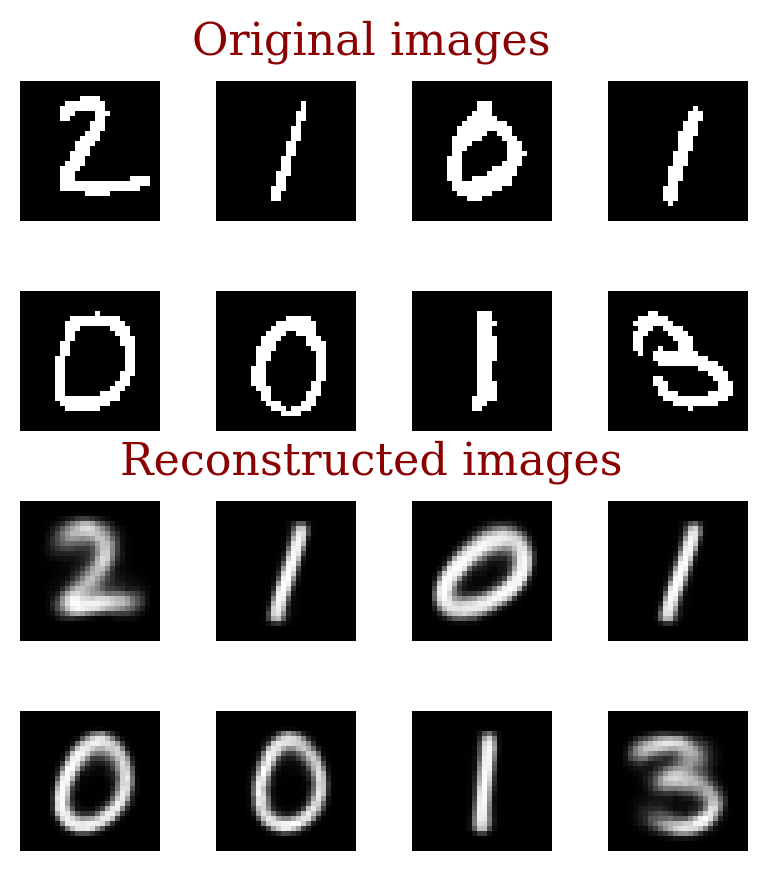

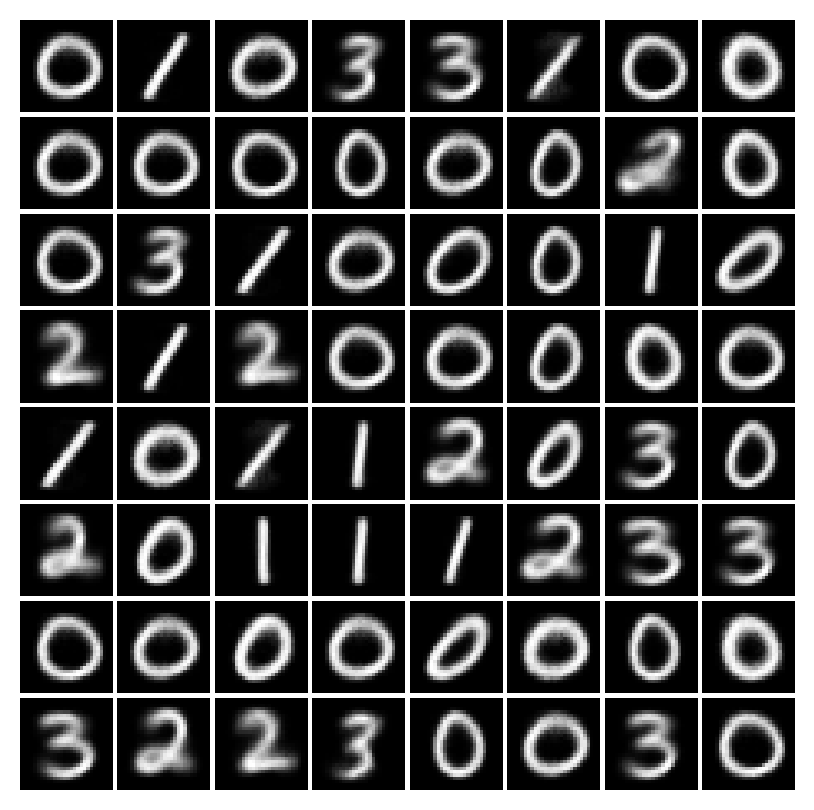

In [3]:
run(1)

epoch: 1, ELBO: 102.6087, BCE: 83.0484, KLD: 19.5603
epoch: 2, ELBO: 93.3632, BCE: 73.6634, KLD: 19.6998
epoch: 3, ELBO: 89.6140, BCE: 69.8090, KLD: 19.8049
epoch: 4, ELBO: 88.5025, BCE: 68.2246, KLD: 20.2779
epoch: 5, ELBO: 85.2913, BCE: 65.0473, KLD: 20.2440
epoch: 6, ELBO: 84.3383, BCE: 63.6865, KLD: 20.6517
epoch: 7, ELBO: 83.2070, BCE: 63.0387, KLD: 20.1683
epoch: 8, ELBO: 82.8386, BCE: 61.8617, KLD: 20.9769
epoch: 9, ELBO: 81.4695, BCE: 60.5795, KLD: 20.8900
epoch: 10, ELBO: 80.6994, BCE: 59.9239, KLD: 20.7756
epoch: 11, ELBO: 80.3413, BCE: 59.1816, KLD: 21.1597
epoch: 12, ELBO: 79.4712, BCE: 58.7281, KLD: 20.7431
epoch: 13, ELBO: 79.0813, BCE: 58.3749, KLD: 20.7064
epoch: 14, ELBO: 78.8645, BCE: 57.8126, KLD: 21.0519
epoch: 15, ELBO: 79.0678, BCE: 58.1772, KLD: 20.8906
epoch: 16, ELBO: 79.1276, BCE: 57.9938, KLD: 21.1338
epoch: 17, ELBO: 78.7174, BCE: 57.9904, KLD: 20.7270
epoch: 18, ELBO: 78.1301, BCE: 56.9590, KLD: 21.1711
epoch: 19, ELBO: 78.2561, BCE: 57.0286, KLD: 21.2276
e

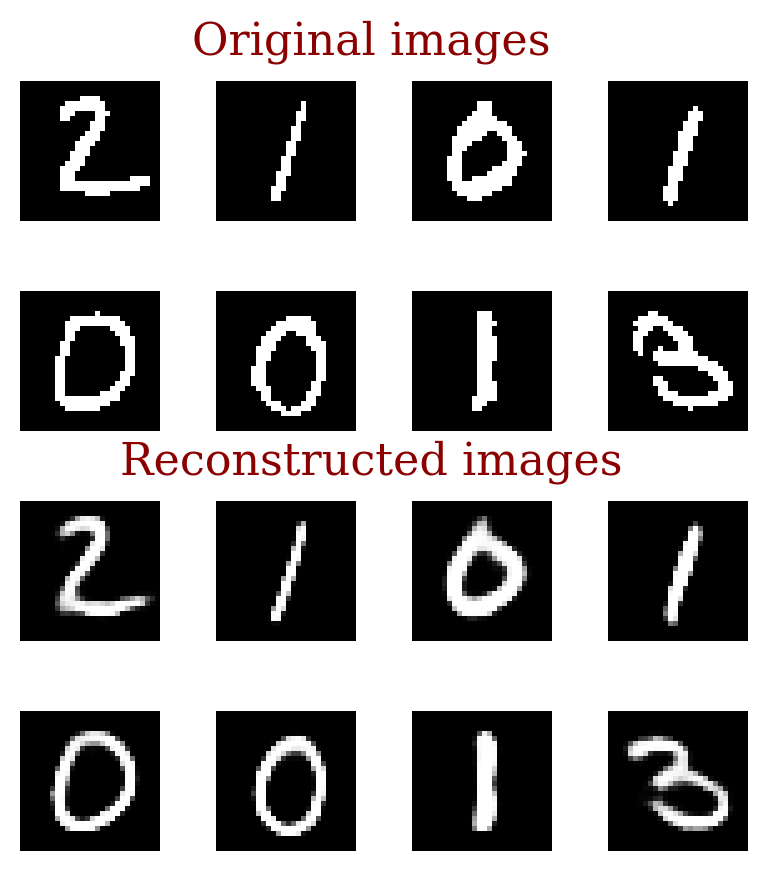

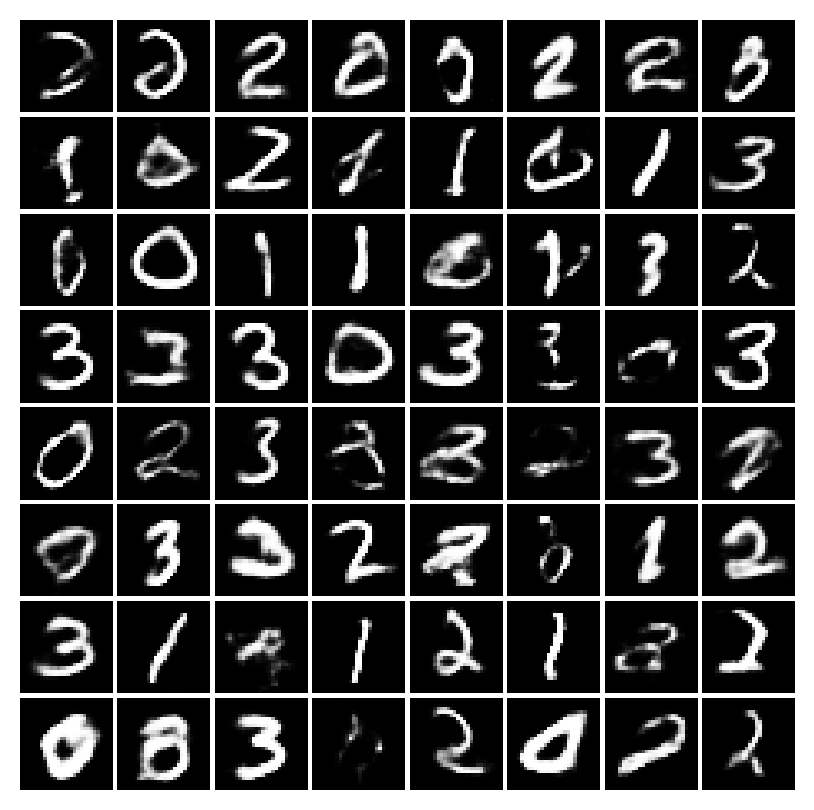

In [4]:
run(10)

epoch: 1, ELBO: 101.9824, BCE: 75.0297, KLD: 26.9527
epoch: 2, ELBO: 92.0408, BCE: 64.1765, KLD: 27.8643
epoch: 3, ELBO: 87.9924, BCE: 58.8937, KLD: 29.0987
epoch: 4, ELBO: 83.4284, BCE: 54.8358, KLD: 28.5926
epoch: 5, ELBO: 82.4064, BCE: 52.4571, KLD: 29.9493
epoch: 6, ELBO: 80.4521, BCE: 51.8750, KLD: 28.5771
epoch: 7, ELBO: 79.8964, BCE: 50.3481, KLD: 29.5483
epoch: 8, ELBO: 79.4857, BCE: 48.8389, KLD: 30.6468
epoch: 9, ELBO: 78.1868, BCE: 48.7325, KLD: 29.4543
epoch: 10, ELBO: 78.7049, BCE: 49.1906, KLD: 29.5143
epoch: 11, ELBO: 77.3412, BCE: 48.1403, KLD: 29.2009
epoch: 12, ELBO: 77.0965, BCE: 48.0538, KLD: 29.0427
epoch: 13, ELBO: 76.2983, BCE: 46.4441, KLD: 29.8542
epoch: 14, ELBO: 75.9705, BCE: 46.4612, KLD: 29.5092
epoch: 15, ELBO: 75.7862, BCE: 45.0451, KLD: 30.7411
epoch: 16, ELBO: 76.3776, BCE: 47.3323, KLD: 29.0453
epoch: 17, ELBO: 75.5356, BCE: 45.7912, KLD: 29.7445
epoch: 18, ELBO: 75.0100, BCE: 45.3049, KLD: 29.7051
epoch: 19, ELBO: 75.1167, BCE: 45.4498, KLD: 29.6669
e

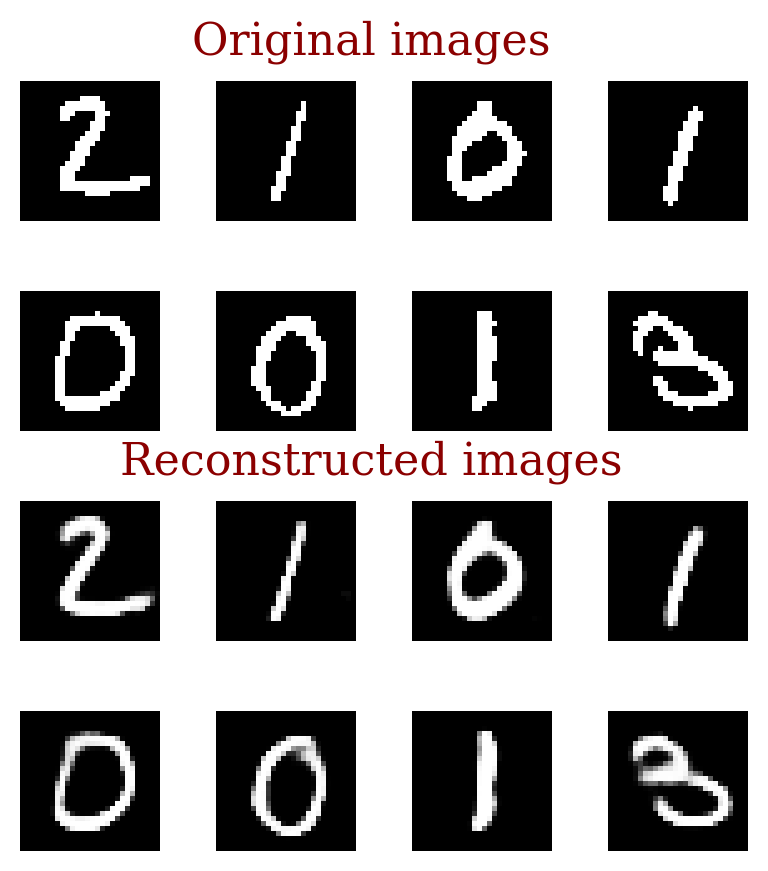

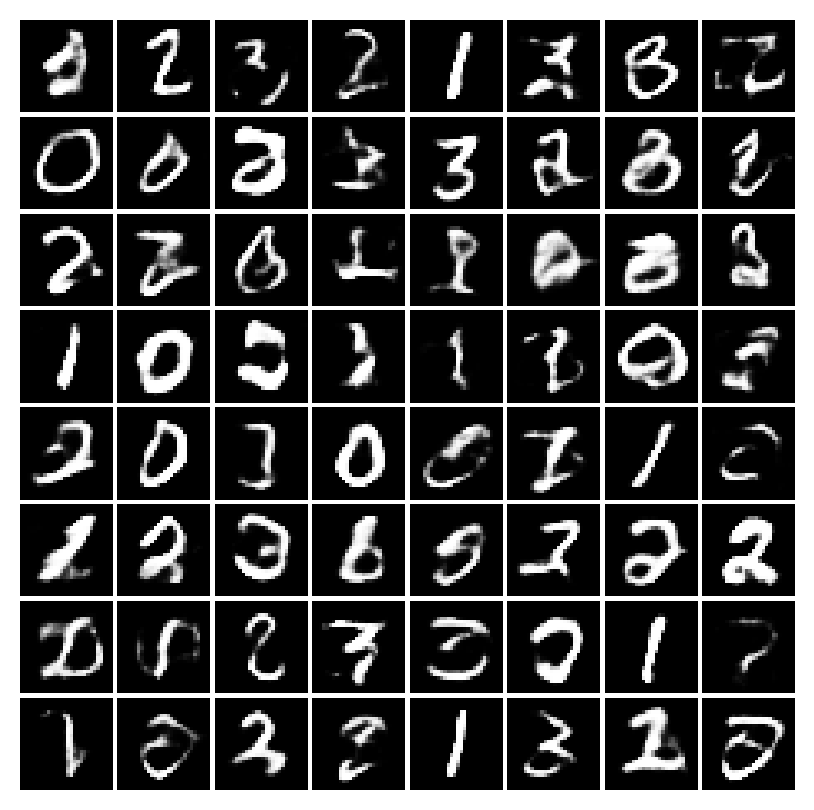

In [5]:
run(20)

epoch: 1, ELBO: 110.1986, BCE: 77.9182, KLD: 32.2805
epoch: 2, ELBO: 99.0159, BCE: 65.4912, KLD: 33.5248
epoch: 3, ELBO: 93.4359, BCE: 60.4259, KLD: 33.0100
epoch: 4, ELBO: 89.4488, BCE: 56.7690, KLD: 32.6798
epoch: 5, ELBO: 87.4535, BCE: 54.6800, KLD: 32.7735
epoch: 6, ELBO: 84.9079, BCE: 52.0204, KLD: 32.8875
epoch: 7, ELBO: 83.4905, BCE: 49.8210, KLD: 33.6695
epoch: 8, ELBO: 82.3829, BCE: 49.4842, KLD: 32.8987
epoch: 9, ELBO: 81.3019, BCE: 47.7207, KLD: 33.5812
epoch: 10, ELBO: 80.3040, BCE: 47.8306, KLD: 32.4734
epoch: 11, ELBO: 79.2076, BCE: 46.9401, KLD: 32.2675
epoch: 12, ELBO: 78.5936, BCE: 45.9852, KLD: 32.6084
epoch: 13, ELBO: 77.9661, BCE: 44.7863, KLD: 33.1798
epoch: 14, ELBO: 77.7844, BCE: 44.7580, KLD: 33.0264
epoch: 15, ELBO: 77.5327, BCE: 44.5517, KLD: 32.9810
epoch: 16, ELBO: 77.1893, BCE: 44.2435, KLD: 32.9458
epoch: 17, ELBO: 76.2882, BCE: 43.5922, KLD: 32.6960
epoch: 18, ELBO: 75.8700, BCE: 42.8617, KLD: 33.0083
epoch: 19, ELBO: 75.8118, BCE: 42.7164, KLD: 33.0954
e

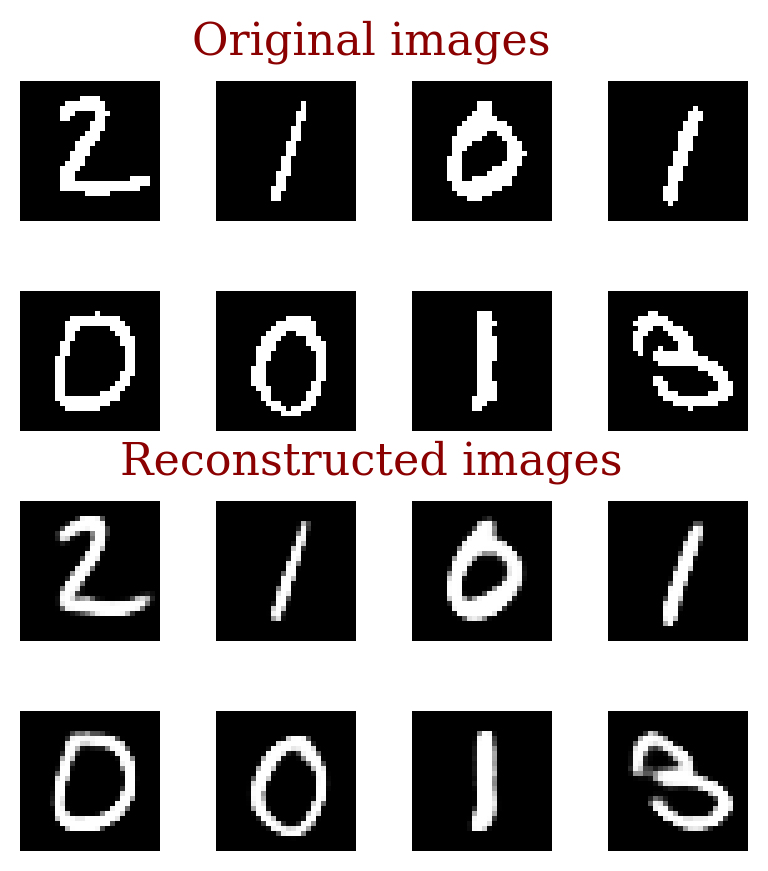

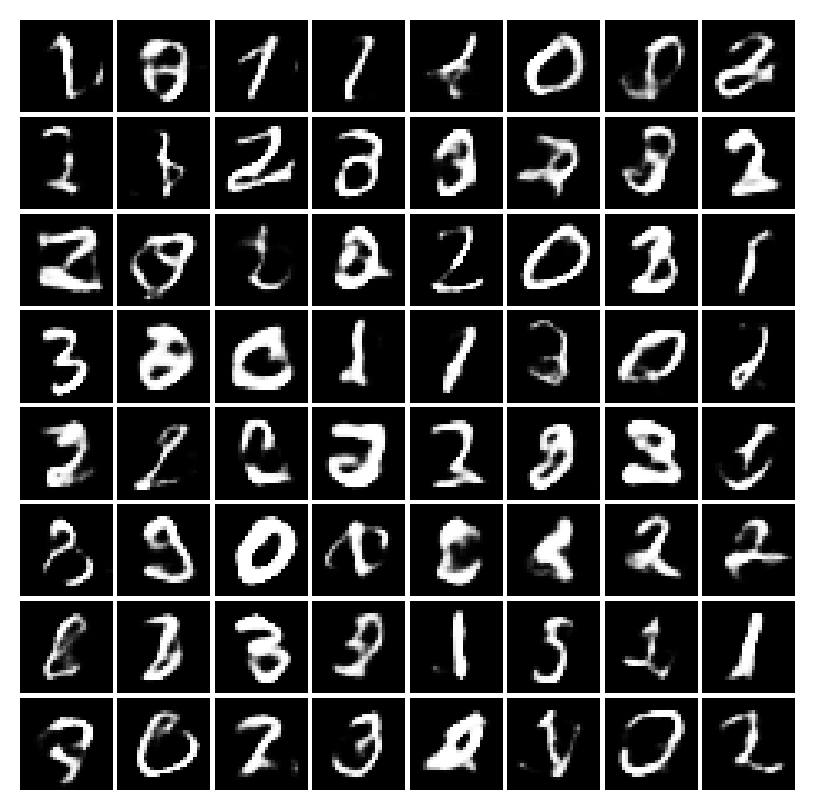

In [6]:
run(50)

epoch: 1, ELBO: 121.5306, BCE: 90.0876, KLD: 31.4430
epoch: 2, ELBO: 108.4259, BCE: 76.6001, KLD: 31.8258
epoch: 3, ELBO: 100.4378, BCE: 68.7363, KLD: 31.7015
epoch: 4, ELBO: 94.6646, BCE: 62.5102, KLD: 32.1544
epoch: 5, ELBO: 90.1763, BCE: 58.3576, KLD: 31.8188
epoch: 6, ELBO: 87.0198, BCE: 55.9941, KLD: 31.0257
epoch: 7, ELBO: 84.9333, BCE: 54.3918, KLD: 30.5416
epoch: 8, ELBO: 82.9027, BCE: 52.0850, KLD: 30.8177
epoch: 9, ELBO: 81.1807, BCE: 50.1347, KLD: 31.0460
epoch: 10, ELBO: 79.8851, BCE: 49.6415, KLD: 30.2436
epoch: 11, ELBO: 78.6138, BCE: 48.2785, KLD: 30.3354
epoch: 12, ELBO: 78.0709, BCE: 48.2807, KLD: 29.7902
epoch: 13, ELBO: 77.5033, BCE: 46.5147, KLD: 30.9886
epoch: 14, ELBO: 76.6450, BCE: 45.9851, KLD: 30.6599
epoch: 15, ELBO: 76.1843, BCE: 46.2007, KLD: 29.9836
epoch: 16, ELBO: 75.7195, BCE: 45.4092, KLD: 30.3103
epoch: 17, ELBO: 75.4078, BCE: 45.0584, KLD: 30.3494
epoch: 18, ELBO: 75.0265, BCE: 44.8970, KLD: 30.1296
epoch: 19, ELBO: 74.7735, BCE: 43.6715, KLD: 31.1020

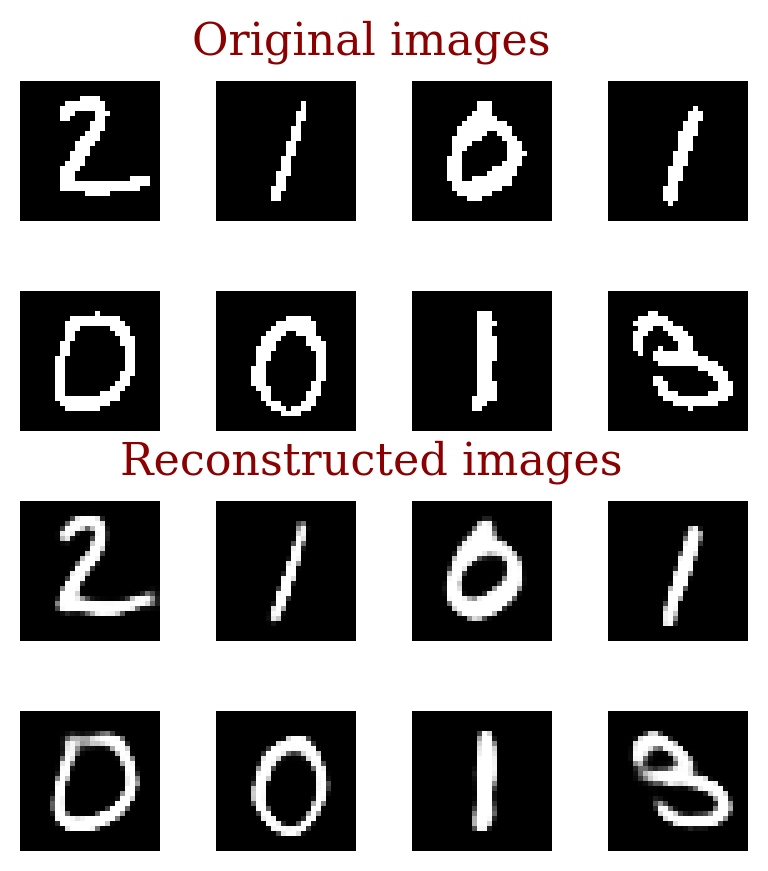

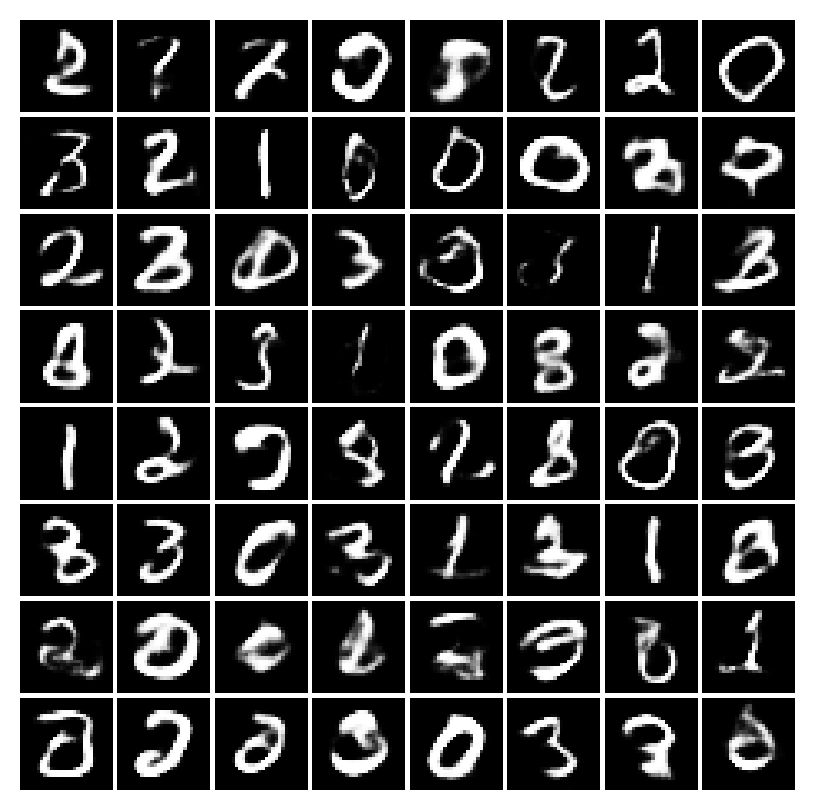

In [7]:
run(100)